# Subset a test data set

* Subset (AWRA?) daily data sets to a more manageable size for initial elaboration. ACT or Tassie.

## Dependencies imports


In [1]:
import xarray as xr
import os
import sys
import pandas as pd
from functools import wraps
import numpy as np

import matplotlib.pyplot as plt

In [2]:
import seaborn as sns  # noqa, pandas aware plotting library

In [3]:
if ('SP_SRC' in os.environ):
    root_src_dir = os.environ['SP_SRC']
elif sys.platform == 'win32':
    root_src_dir = r'C:\src\csiro\stash\silverpieces'
else:
    root_src_dir = '/home/per202/src/csiro/stash/silverpieces'

pkg_src_dir = root_src_dir
sys.path.append(pkg_src_dir)

In [4]:
if ('SP_DATA' in os.environ):
    root_data_dir = os.environ['SP_DATA']
elif sys.platform == 'win32':
    root_data_dir = r'C:\data\silverpieces'
else:
    root_data_dir = '/home/per202/data/silverpieces'


In [5]:
#from silverpieces.blah import *

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
from siphon.catalog import TDSCatalog

## subset data to tasmania

I did not manage to get the [AWRA data served by thredds](http://data-mel.it.csiro.au/thredds). 

Try another approach:


In [8]:
ds_desc = 'http://data-cbr.it.csiro.au/thredds/catalog/catch_all/Digiscape_Climate_Data_Portal/silo/climate/catalog.xml?dataset=allDatasetScan/Digiscape_Climate_Data_Portal/silo/climate/daily_rain.nc'
catalog = TDSCatalog(ds_desc)

In [9]:
# Load the dataset
cat = catalog
dataset_name = sorted(cat.datasets.keys())[-1]

In [10]:
dataset_name

'daily_rain.nc'

In [11]:
dataset = cat.datasets[dataset_name]
ds = dataset.remote_access(service='OPENDAP')

In [12]:
from xarray.backends import NetCDF4DataStore

In [13]:
ds = NetCDF4DataStore(ds)
ds = xr.open_dataset(ds)

In [14]:
x = ds.daily_rain

In [15]:
x

<xarray.DataArray 'daily_rain' (time: 22280, lat: 681, lon: 841)>
[12760223880 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 112.0 112.0 112.1 112.2 ... 153.8 153.9 153.9 154.0
  * lat      (lat) float64 -44.0 -43.95 -43.9 -43.85 ... -10.1 -10.05 -10.0
  * time     (time) datetime64[ns] 1959-01-01 1959-01-02 ... 2019-12-31
Attributes:
    long_name:    Daily rainfall
    units:        mm
    _ChunkSizes:  [1000   40   40]

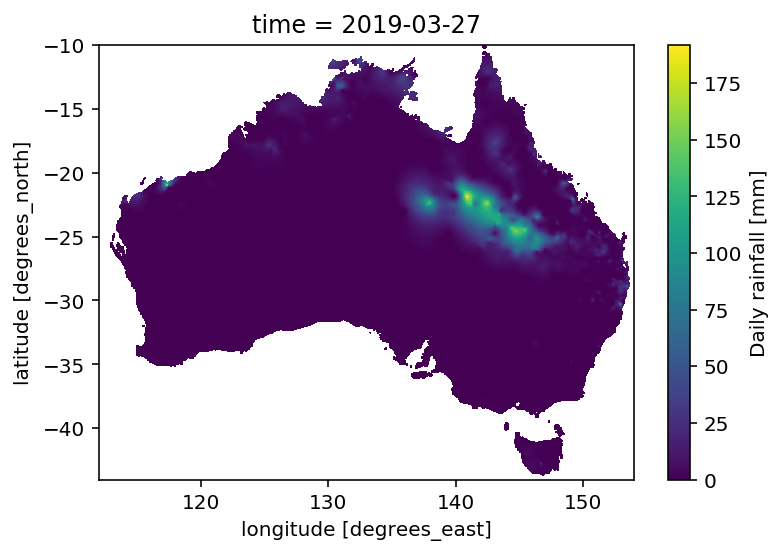

In [16]:
x.isel(time=22000).plot()

In [17]:
%time b_box = x.isel(lat=slice(600,700), lon=slice(650,750))

CPU times: user 744 µs, sys: 51 µs, total: 795 µs
Wall time: 718 µs


CPU times: user 89.8 ms, sys: 8.1 ms, total: 97.9 ms
Wall time: 269 ms


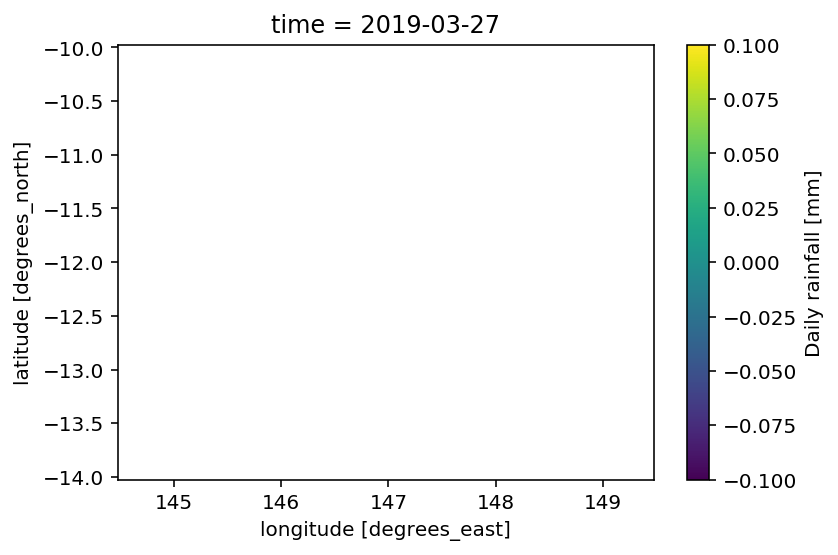

In [18]:
%time b_box.isel(time=22000).plot()

In [19]:
%time plt.show()

CPU times: user 12 µs, sys: 1 µs, total: 13 µs
Wall time: 15.3 µs


In [20]:
b_box

<xarray.DataArray 'daily_rain' (time: 22280, lat: 81, lon: 100)>
[180468000 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 144.5 144.6 144.6 144.7 ... 149.3 149.3 149.4 149.4
  * lat      (lat) float64 -14.0 -13.95 -13.9 -13.85 ... -10.1 -10.05 -10.0
  * time     (time) datetime64[ns] 1959-01-01 1959-01-02 ... 2019-12-31
Attributes:
    long_name:    Daily rainfall
    units:        mm
    _ChunkSizes:  [1000   40   40]

In [21]:
lc = x.coords['lon']
la = x.coords['lat']
lt = x.coords['time']

In [22]:
lt

<xarray.DataArray 'time' (time: 22280)>
array(['1959-01-01T00:00:00.000000000', '1959-01-02T00:00:00.000000000',
       '1959-01-03T00:00:00.000000000', ..., '2019-12-29T00:00:00.000000000',
       '2019-12-30T00:00:00.000000000', '2019-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01 1959-01-02 ... 2019-12-31
Attributes:
    standard_name:  time
    axis:           T
    _ChunkSizes:    1000

In [23]:
start_time = pd.to_datetime('2007-01-01')
end_time = pd.to_datetime('2018-12-31')


In [25]:
#query.lonlat_box(north=-40, south=-44, east=149, west=144).time(tt)
tassie = x.loc[dict(lon=lc[(lc>144)&(lc<149)], lat=la[(la>-44)&(la<-40)], time=slice(start_time, end_time))]

In [26]:
tassie

<xarray.DataArray 'daily_rain' (time: 4383, lat: 79, lon: 99)>
[34279443 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 144.1 144.1 144.2 144.2 ... 148.8 148.8 148.9 148.9
  * lat      (lat) float64 -43.95 -43.9 -43.85 -43.8 ... -40.15 -40.1 -40.05
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2018-12-31
Attributes:
    long_name:    Daily rainfall
    units:        mm
    _ChunkSizes:  [1000   40   40]

CPU times: user 6.89 s, sys: 890 ms, total: 7.78 s
Wall time: 2min 38s


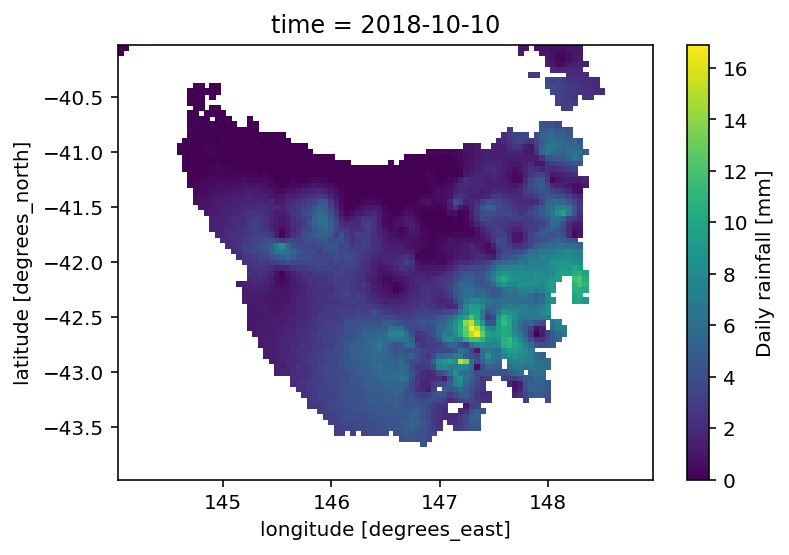

In [28]:
%time tassie.isel(time=4300).plot()

In [ ]:
fn = os.path.join(root_data_dir, 'tassie_silo_rain.nc')
if not os.path.exists(fn):
    tassie.to_netcdf(os.path.join(root_data_dir, 'tassie_silo_rain.nc'))

In [ ]:
del(tassie)

In [ ]:
tassie = xr.open_dataset(os.path.join(root_data_dir, 'tassie_silo_rain.nc'))

In [ ]:
tassie

In [ ]:
dr = tassie.daily_rain

In [ ]:
dr.isel(time=4300).plot()

## Use cases

### 3 year period statistic compared to all 3 years periods in the historical record

We want to be able to compare a grid of statistics for a period compared to all periods of similar lengths.
The start and end of the period should be as arbitrary as possible. The sliding window could however be limited or fixed to a year: it is probably moot to compare windows with shifted seasonality. 

#### How does the cumulated rainfall 2016-2018 over TAS compare with all 3 year periods over the record?


In [ ]:
start_time = pd.to_datetime('2016-01-01')
end_time = pd.to_datetime('2018-12-31')

In [ ]:
dr.isel(time = 1)

In [ ]:
blah = dr.loc[dict(time=slice(start_time, end_time))].sum(dim='time',skipna=False)

In [ ]:
blah.plot()

In [ ]:
TIME_DIMNAME = 'time'


blah = dr.loc[dict(time=slice(start_time, end_time))].sum(dim='time',skipna=False)

In [ ]:
start_time = pd.to_datetime('2007-01-01')
end_time = pd.to_datetime('2009-12-31')

In [ ]:
from datetime import date
from dateutil.relativedelta import relativedelta # $ pip install python-dateutil

In [ ]:
print(start_time + relativedelta(years=+1))

In [ ]:
cumulated = [dr.loc[dict(time=slice(start_time + relativedelta(years=year), end_time+ relativedelta(years=year)))].sum(dim='time',skipna=False) for year in range(10)]

In [ ]:
cumulated[0].plot()

In [ ]:
blah = xr.concat(cumulated)

In [ ]:
blah

In [ ]:
blah = xr.auto_combine([xr.Dataset(cumulated[i]) for i in range(len(cumulated))])

g_simple = t.plot(x='lon', y='lat', col='time', col_wrap=3)